<a href="https://colab.research.google.com/github/datbibip/ThucHanh1/blob/master/De6_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 1. Load dữ liệu
df = pd.read_csv('/content/DOM_hourly.csv', parse_dates=['Datetime'], index_col='Datetime')
data_series = df['DOM_MW']


In [ ]:
data_series.head()

,DOM_MW
Datetime,
2005-12-31 01:00:00,9389.0
2005-12-31 02:00:00,9070.0
2005-12-31 03:00:00,9001.0
2005-12-31 04:00:00,9042.0
2005-12-31 05:00:00,9132.0


Missing values theo cột:
 DOM_MW    0
dtype: int64


<ipython-input-5-6f60f8c287de>:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


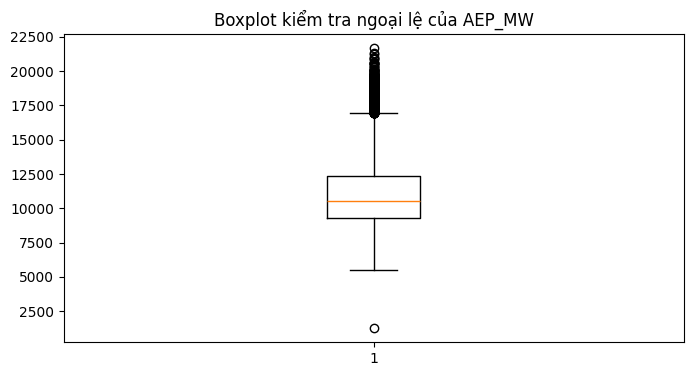

In [ ]:

# 3. Kiểm tra missing values
print("Missing values theo cột:\n", df.isna().sum())

# Nếu có missing values, xử lý (ở đây giả sử không hoặc fill forward)
df = df.fillna(method='ffill')

# 4. Chọn cột cần dùng (ví dụ 'Appliances' - tiêu thụ năng lượng)
series = df['DOM_MW']

# 5. Kiểm tra ngoại lệ bằng biểu đồ boxplot
plt.figure(figsize=(8,4))
plt.boxplot(series)
plt.title('Boxplot kiểm tra ngoại lệ của AEP_MW')
plt.show()

# Nếu cần xử lý ngoại lệ, ví dụ loại bỏ giá trị quá lớn (ví dụ > quantile 99%)
q99 = series.quantile(0.99)
series_clean = series.copy()
series_clean[series_clean > q99] = q99

# 6. Chuẩn hóa dữ liệu (nếu bạn muốn) - ví dụ Min-Max scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

series_scaled = scaler.fit_transform(series_clean.values.reshape(-1,1))
series_scaled = pd.Series(series_scaled.flatten(), index=series_clean.index)

In [ ]:
series_scaled

,0
Datetime,
2005-12-31 01:00:00,0.499383
2005-12-31 02:00:00,0.479803
2005-12-31 03:00:00,0.475567
2005-12-31 04:00:00,0.478084
2005-12-31 05:00:00,0.483608
...,...
2018-01-01 20:00:00,1.000000
2018-01-01 21:00:00,1.000000
2018-01-01 22:00:00,1.000000


In [ ]:
# 2. Chia train - test
split_index = int(len(series_scaled) * 0.8)
train = series_scaled[:split_index]
test = series_scaled[split_index:]


In [ ]:
# 3. Simple Exponential Smoothing thủ công
def simple_exponential_smoothing(data, alpha):
    S = [data[0]]
    for t in range(1, len(data)):
        St = alpha * data[t] + (1 - alpha) * S[-1]
        S.append(St)
    return S

alpha = 0.3
ses_smooth = simple_exponential_smoothing(train.tolist(), alpha)
ses_forecast = [ses_smooth[-1]] * len(test)

In [ ]:
# 5. Dự báo trên tập test
arima_forecast = arima_fit.forecast(steps=len(test))

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [ ]:
# 6. Hàm đánh giá
def evaluate(true, pred):
    mae = np.mean(np.abs(true - pred))
    rmse = np.sqrt(np.mean((true - pred)**2))
    mape = np.mean(np.abs((true - pred) / true)) * 100
    return mae, rmse, mape

mae_ses, rmse_ses, mape_ses = evaluate(test.values, np.array(ses_forecast))
mae_arima, rmse_arima, mape_arima = evaluate(test.values, arima_forecast.values)


print(f"SES - MAE: {mae_ses:.3f}, RMSE: {rmse_ses:.3f}, MAPE: {mape_ses:.2f}%")
print(f"ARIMA{arima_order} - MAE: {mae_arima:.3f}, RMSE: {rmse_arima:.3f}, MAPE: {mape_arima:.2f}%")


SES - MAE: 0.138, RMSE: 0.162, MAPE: 25.36%
ARIMA(2, 1, 2) - MAE: 0.126, RMSE: 0.152, MAPE: 22.09%


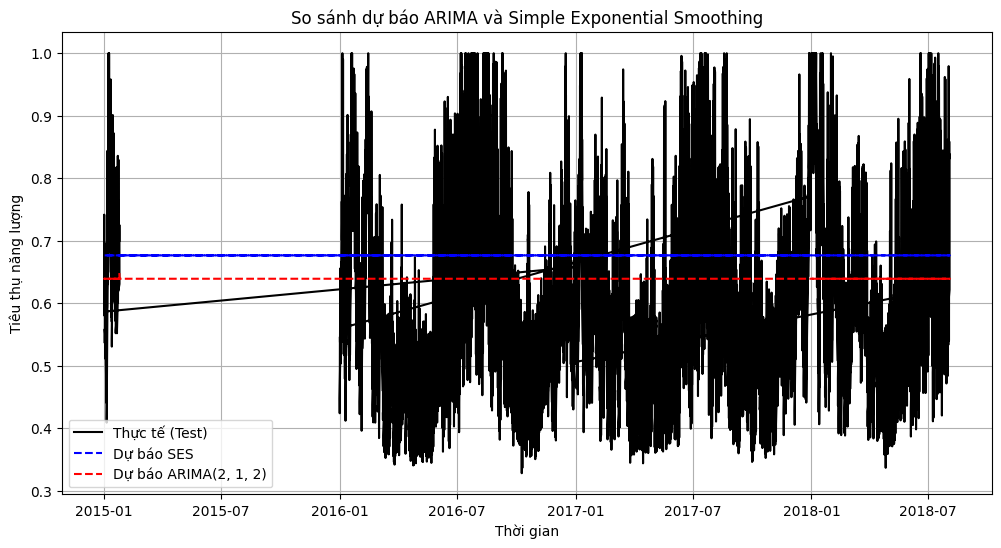

In [ ]:
# 7. Visualize kết quả
plt.figure(figsize=(12,6))
plt.plot(test.index, test, label='Thực tế (Test)', color='black')
plt.plot(test.index, ses_forecast, label='Dự báo SES', linestyle='--', color='blue')
plt.plot(test.index, arima_forecast, label=f'Dự báo ARIMA{arima_order}', linestyle='--', color='red')
plt.title('So sánh dự báo ARIMA và Simple Exponential Smoothing')
plt.xlabel('Thời gian')
plt.ylabel('Tiêu thụ năng lượng')
plt.legend()
plt.grid(True)
plt.show()